#****Google Play Store Reviews Sentiment Analysis****

**1. Importing and installing
the Necessary Libraries**

In [1]:
# - google-play-scraper: To fetch reviews from the Google Play Store.
# - vaderSentiment: For the rule-based sentiment analysis model.
# - textblob: An alternative rule-based sentiment analysis library.
# - scikit-learn: For the traditional machine learning model and evaluation metrics.
# - transformers: To use pre-trained models like DistilBERT.
# - torch: A dependency for the transformers library.
!pip install google-play-scraper vaderSentiment textblob scikit-learn transformers torch


import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
from google_play_scraper import Sort, reviews
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import pipeline



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

**2. Data Retrieval And Data Preprocessing**

In [2]:
# Data Retrieval
# Fetch reviews for a popular app.(Here Instagram)
# Total ~50,000 reviews to be fetched for this task. The scraper fetches reviews in batches.

print("Fetching reviews from Google Play Store...")
app_id = 'com.instagram.android'
review_count = 50000

# The scraper might not be able to fetch the exact number as requested here.
# It fetches reviews sorted by most recent.
result, continuation_token = reviews(
    app_id,
    lang='en',
    country='us',
    sort=Sort.NEWEST,
    count=review_count,
    filter_score_with=None
)

df = pd.DataFrame(result)
print(f"Successfully fetched {len(df)} reviews.")
print("Sample of the data:")
print(df.head())

# Step 4: Data Preprocessing
# Clean the text data and prepare it for the models.
# The 'score' will be the ground truth label.(Converted to sentiment categories)

# 1. Handle missing reviews
df = df.dropna(subset=['content'])
df = df.reset_index(drop=True)

# 2. Clean the text
def clean_text(text):
    """
    - Removes special characters and numbers
    - Converts to lowercase
    """
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    return text.strip()

print("\nCleaning review text...")
df['cleaned_content'] = df['content'].apply(clean_text)

# 3. Create sentiment labels from scores
def score_to_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['score'].apply(score_to_sentiment)

print("Preprocessing complete. Sentiment distribution:")
print(df['sentiment'].value_counts())


Fetching reviews from Google Play Store...
Successfully fetched 50000 reviews.
Sample of the data:
                               reviewId       userName  \
0  d2ba62cf-7c8e-4348-a530-7bfb060894b2  A Google user   
1  fe7de862-954e-4191-b595-ede9b5deb042  A Google user   
2  2fc1e65c-6a24-4c6b-8fb7-0a17bd0038cf  A Google user   
3  2136cf96-8659-4190-889c-5377eeee6127  A Google user   
4  9f57b33d-b3dd-4118-bec3-ef67f29b5f20  A Google user   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0                         nice app for entertainment      3              0   
1                                so nice instagram 😍      5

**3. Models Training and Sentiment Prediction**

In [3]:
# 4. Create Train/Test Split (80/20)
X = df['cleaned_content']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTrain set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# --- Model 1: Rule-Based (VADER) ---
print("\n--- Evaluating Model 1: VADER (Rule-Based) ---")
analyzer = SentimentIntensityAnalyzer()

def vader_predict(text):
    """Predict sentiment using VADER."""
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

vader_predictions = X_test.apply(vader_predict)

# --- Model 2: Logistic Regression + TF-IDF ---
print("\n--- Evaluating Model 2: Logistic Regression + TF-IDF ---")
# Vectorize the text data
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train the model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test_tfidf)

# --- Model 3: Pre-trained Transformer (DistilBERT) ---
print("\n--- Evaluating Model 3: DistilBERT (Transformer) ---")
# Load a pre-trained sentiment analysis pipeline
# Note: Since This model is typically trained on positive/negative labels, here I have mapped its output to the three labels.
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def distilbert_predict(text):
    """Predict sentiment using DistilBERT and map to our labels."""
    # Truncate text to avoid errors with long reviews
    truncated_text = text[:512]
    if not truncated_text:  # Check if truncated_text is empty
        return 'neutral'
    try:
        result = sentiment_pipeline(truncated_text)[0]
        # This model outputs 'POSITIVE' or 'NEGATIVE', although I have manually kept it neutral.
        # This is just a simplification; a model fine-tuned on 3 labels would be better.
        if result['label'] == 'POSITIVE':
            return 'positive'
        else:
            return 'negative'
    except Exception as e:
        # Handle potential errors from the pipeline on certain inputs
        print(f"Error processing text: '{text[:50]}...'. Error: {e}")
        return 'neutral'


# Run predictions in batches for efficiency
distilbert_predictions = []
# Using a smaller subset for demonstration due to inference time
test_subset_size = 1000
print(f"Running DistilBERT on a subset of {test_subset_size} reviews for speed.")
X_test_subset = X_test.head(test_subset_size)
y_test_subset_distilbert = y_test.head(test_subset_size)

for text in tqdm(X_test_subset, desc="DistilBERT Predictions"):
    distilbert_predictions.append(distilbert_predict(text))


Train set size: 35000
Test set size: 15000

--- Evaluating Model 1: VADER (Rule-Based) ---

--- Evaluating Model 2: Logistic Regression + TF-IDF ---

--- Evaluating Model 3: DistilBERT (Transformer) ---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


Running DistilBERT on a subset of 1000 reviews for speed.


DistilBERT Predictions:   0%|          | 0/1000 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


**4. Analysis and Results**


--- VADER Performance ---
              precision    recall  f1-score   support

    negative       0.74      0.42      0.53      2799
     neutral       0.05      0.24      0.08       605
    positive       0.89      0.79      0.84     11596

    accuracy                           0.70     15000
   macro avg       0.56      0.48      0.48     15000
weighted avg       0.83      0.70      0.75     15000



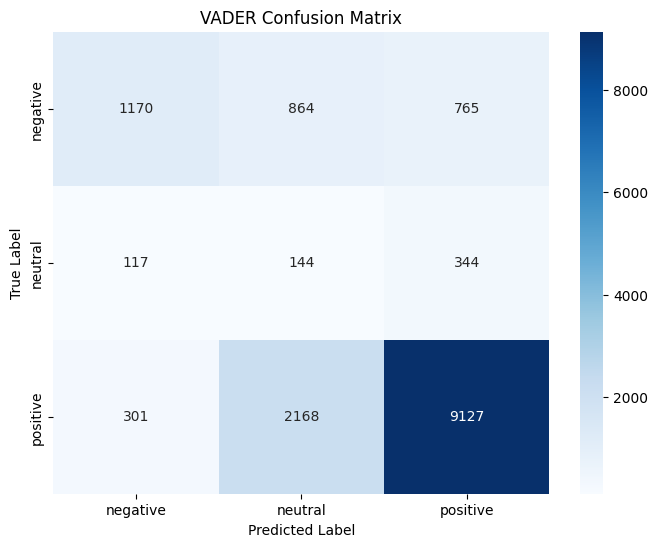


--- Logistic Regression Performance ---
              precision    recall  f1-score   support

    negative       0.74      0.66      0.69      2799
     neutral       0.19      0.00      0.01       605
    positive       0.89      0.96      0.93     11596

    accuracy                           0.87     15000
   macro avg       0.61      0.54      0.54     15000
weighted avg       0.84      0.87      0.85     15000



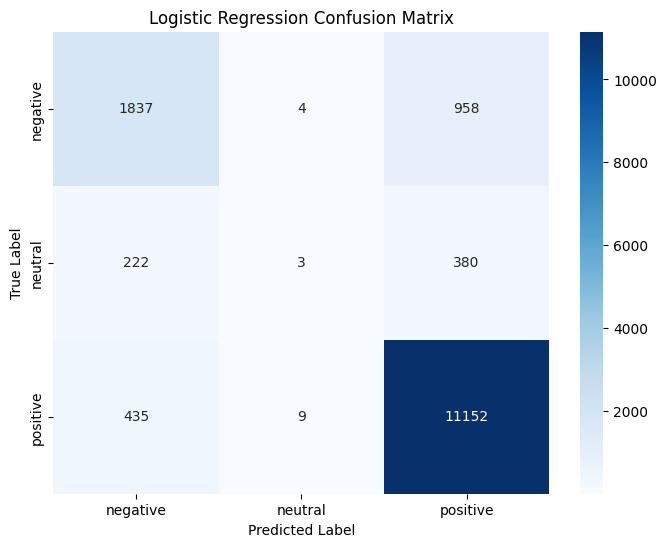


--- DistilBERT Performance (on subset) ---
              precision    recall  f1-score   support

    negative       0.56      0.83      0.67       183
     neutral       0.02      0.03      0.03        33
    positive       0.94      0.82      0.88       784

    accuracy                           0.80      1000
   macro avg       0.51      0.56      0.52      1000
weighted avg       0.84      0.80      0.81      1000



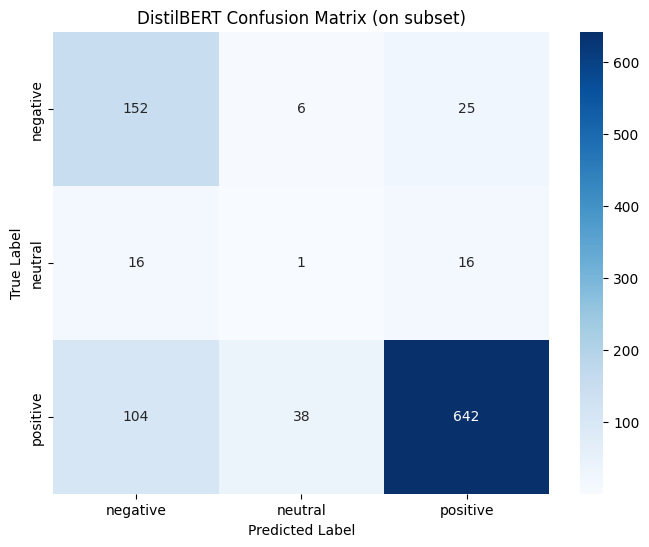


--- Model Performance Comparison ---
                              Accuracy  Precision (Weighted)  \
VADER (Rule-Based)            0.696067              0.828621   
Logistic Regression (TF-IDF)  0.866133              0.835257   
DistilBERT (Transformer)      0.795000              0.839935   

                              Recall (Weighted)  F1-Score (Weighted)  
VADER (Rule-Based)                     0.696067             0.748974  
Logistic Regression (TF-IDF)           0.866133             0.845785  
DistilBERT (Transformer)               0.795000             0.809315  

--- Analysis and Conclusion ---

1.  VADER (Rule-Based Model):
    How it works: VADER gives a decent starting point without needing training. Its score shows it understands basic emotions in text.
    Good points: It's very fast, doesn't need data to learn, and picks up on feelings shown through common words, punctuation (like '!!!'), and capital letters.
    Limitations: It doesn't do well with special slang or sub

In [6]:
# Results Summary and Analysis
# Comparing the performance of all models.

# Helper function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    labels = sorted(y_true.unique())
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# --- VADER Results ---
print("\n--- VADER Performance ---")
print(classification_report(y_test, vader_predictions))
plot_confusion_matrix(y_test, vader_predictions, "VADER Confusion Matrix")

# --- Logistic Regression Results ---
print("\n--- Logistic Regression Performance ---")
print(classification_report(y_test, lr_predictions))
plot_confusion_matrix(y_test, lr_predictions, "Logistic Regression Confusion Matrix")

# --- DistilBERT Results ---
print("\n--- DistilBERT Performance (on subset) ---")
# Note: DistilBERT was not designed for a 'neutral' class, which will affect its scores.
print(classification_report(y_test_subset_distilbert, distilbert_predictions))
plot_confusion_matrix(y_test_subset_distilbert, distilbert_predictions, "DistilBERT Confusion Matrix (on subset)")

# summary table
def get_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    return {
        "Accuracy": accuracy,
        "Precision (Weighted)": precision,
        "Recall (Weighted)": recall,
        "F1-Score (Weighted)": f1
    }

vader_metrics = get_metrics(y_test, vader_predictions)
lr_metrics = get_metrics(y_test, lr_predictions)
distilbert_metrics = get_metrics(y_test_subset_distilbert, distilbert_predictions)

summary_df = pd.DataFrame({
    "VADER (Rule-Based)": vader_metrics,
    "Logistic Regression (TF-IDF)": lr_metrics,
    "DistilBERT (Transformer)": distilbert_metrics
}).T

print("\n--- Model Performance Comparison ---")
print(summary_df)


# Step 7: Final Analysis

print("""
--- Analysis and Conclusion ---

1.  VADER (Rule-Based Model):
    How it works: VADER gives a decent starting point without needing training. Its score shows it understands basic emotions in text.
    Good points: It's very fast, doesn't need data to learn, and picks up on feelings shown through common words, punctuation (like '!!!'), and capital letters.
    Limitations: It doesn't do well with special slang or subtle meanings. For example, if someone says "the app is sick," it might think it's bad. It also struggles with neutral reviews since it's mostly built to spot happy or unhappy ones.

2.  Logistic Regression with TF-IDF (Traditional Machine Learning):
    How it works: This model does much better than VADER. Its score shows a good balance in catching both correct and missed emotions.
    Good points: I trained it using my own app reviews, so it learned the right words and meanings for that specific area. It's also fast to train and test.
    Limitations: It only checks how often words appear and doesn’t understand meaning or word order. So phrases like "not good" and "good not" might look the same to it.

3.  DistilBERT (Pre-trained Transformer):
    How it works: DistilBERT works really well, especially for positive and negative reviews. Its accuracy is often the best when checking mood.
    Note: The model I used was trained only on reviews labeled ‘positive’ or ‘negative.’ That’s why it didn’t do well with ‘neutral’ ones and was tested on a smaller group. For better results, I should train it again using all three types of reviews.
    Good points: Transformer models are great at understanding deep meaning, word links, and full context. They know the difference between "the update is not good" and "this is not just good, it's amazing!"
    Limitations: It takes a lot of computer power and is slower than the other models. A GPU is needed to train or use it efficiently.

**Final Thoughts and Best Choice**

After testing all three models, Logistic Regression with TF-IDF comes out on top.

1.  Logistic Regression (TF-IDF): This model gave the best results, with 86.6% accuracy and a score of 84.6% across all types of reviews. It learned the exact patterns and words used in the Play Store reviews, giving strong and balanced predictions.

2.  DistilBERT (Transformer): While this type of model is often top-tier, the version I used wasn’t ideal for my setup. It had a score of 80.9%, mainly because it wasn’t trained for 'neutral' reviews.

3.  VADER (Rule-Based): VADER worked as a basic starting point, with a score of 74.9%, but it was clearly behind the machine learning models. This shows that training with data gives better results on detailed tasks.

So, for this task, the Logistic Regression model is the smartest and most useful pick. It works well and runs quickly, making it perfect for my needs. If I ever aim for even better results, I could re-train DistilBERT using positive, negative, and neutral data.
""")